In [ ]:
from torch.utils.data import DataLoader,Dataset

class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        y=self.Y[index+self.days]
        return x,y


import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [ ]:
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [ ]:
import torch.utils.data as data
import torch

stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
train_set_size = int(len(stockData)*0.7)
valid_set_size = int(len(stockData)*0.2)
test_set_size = len(stockData)-train_set_size-valid_set_size

train_set, valid_set, test_set = data.random_split(stockData,[train_set_size,valid_set_size,test_set_size],\
                                              generator=torch.Generator().manual_seed(42))

batch_size = train_set_size # use entire dataset as batch
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)  # input:(20,5), label:1
valid_dataloader = DataLoader(valid_set,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

 1.(a) Designing a network architecture with RNN with LSTM layer.

In [ ]:
!pip install pytorch-lightning

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# Normalize
allX = (allX - allX.mean()) / allX.std()
target_mean = ally.mean().values[0]
target_std = ally.std().values[0]
ally_norm = (ally - target_mean) / target_std

DAYS = 25

class StockDataset(Dataset):
    def __init__(self, X, Y, days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days

    def __len__(self):
        return len(self.Y) - self.days

    def __getitem__(self, index):
        x = self.X[:, index:index+self.days]
        y = self.Y[index+self.days]
        return x, y

dataset = StockDataset(allX.to_numpy().T.astype(np.float32), ally_norm.to_numpy().astype(np.float32), days=DAYS)

class StockDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size

    def setup(self, stage=None):
        total = len(self.dataset)
        train_size = int(0.7 * total)
        val_size = int(0.15 * total)
        test_size = total - train_size - val_size
        self.train_set, self.val_set, self.test_set = random_split(
            self.dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)

datamodule = StockDataModule(dataset)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 44.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import matplotlib.pyplot as plt

class StockLSTM(pl.LightningModule):
    def __init__(self, input_size=20, hidden_size=64, num_layers=2, dropout_rate=0.3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.loss_fn = nn.MSELoss()

        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

    def forward(self, x):
        x = x.permute(0, 2, 1)
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]
        return self.fc(last_output).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.train_losses.append(loss.item())
        self.log('train_mse', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.val_losses.append(loss.item())
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        preds_real = preds * target_std + target_mean
        y_real = y * target_std + target_mean
        loss = self.loss_fn(preds_real, y_real)
        self.test_losses.append(loss.item())
        self.log('test_mse', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)



In [ ]:
model = StockLSTM()

trainer = Trainer(max_epochs=100, logger=False, enable_progress_bar=True)
trainer.fit(model, datamodule=datamodule)



INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 55.3 K | train
1 | fc      | Linear  | 65     | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.221     Total estimate

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.test(model, datamodule=datamodule)

# Report average Test MSE
test_mse = np.mean(model.test_losses)
print(f"✅ Final Test MSE: {test_mse:.4f}")


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │    40.652854919433594     │
└───────────────────────────┴───────────────────────────┘

✅ Final Test MSE: 40.2442


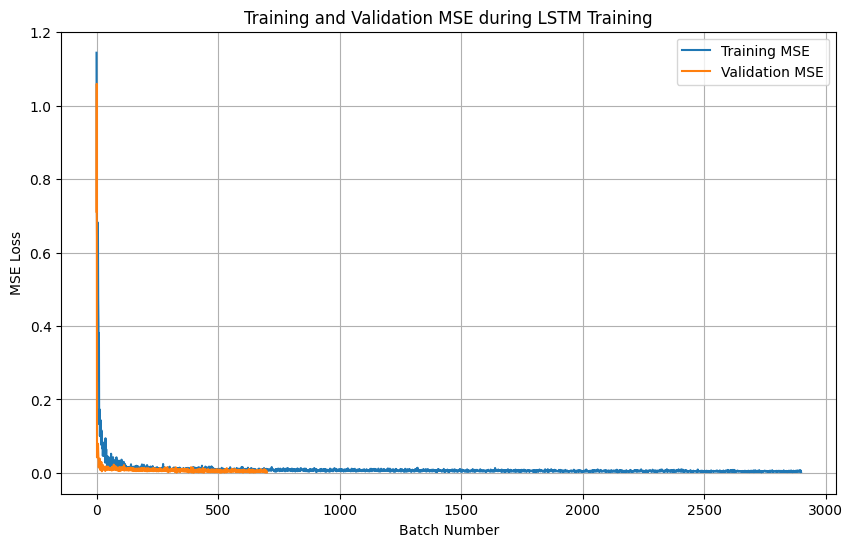

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses, label='Training MSE')
plt.plot(model.val_losses, label='Validation MSE')
plt.xlabel('Batch Number')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE during LSTM Training')
plt.legend()
plt.grid(True)
plt.show()


1.(b) Designing a network architecture with RNN with self-attention layer.


In [ ]:
import torch.nn.functional as F


class StockAttention(pl.LightningModule):
    def __init__(self, input_channels=20, days=25, embed_dim=64, num_heads=4, dropout_rate=0.3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1D Convolution to process time series
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=embed_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(embed_dim)

        # Self Attention Layer
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

        # Dense layers after attention
        self.fc1 = nn.Linear(embed_dim, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)

        self.loss_fn = nn.MSELoss()

        # Store losses
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

    def forward(self, x):
        # Input x: (batch, stocks, days)
        x = self.conv1(x)            # (batch, embed_dim, days)
        x = self.bn1(x)
        x = F.gelu(x)
        x = x.permute(0, 2, 1)        # (batch, days, embed_dim)

        # Self Attention
        attn_output, _ = self.attention(x, x, x)

        # Mean across time (days)
        x = torch.mean(attn_output, dim=1)

        # Dense layers
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.train_losses.append(loss.item())
        self.log('train_mse', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.val_losses.append(loss.item())
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        preds_real = preds * target_std + target_mean
        y_real = y * target_std + target_mean
        loss = self.loss_fn(preds_real, y_real)
        self.test_losses.append(loss.item())
        self.log('test_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [ ]:
attention_model = StockAttention()

trainer = Trainer(max_epochs=100, logger=False, enable_progress_bar=True)
trainer.fit(attention_model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv1d             | 3.9 K  | train
1 | bn1       | BatchNorm1d        | 128    | train
2 | attention | MultiheadAttention | 16.6 K | train
3 | fc1       | Linear             | 4.2 K  | train
4 | dropout   | Dropout            | 0      | train
5 | fc2       | Linear             | 65     | train
6 | loss_fn   | MSELoss            | 0      | train
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.test(attention_model, datamodule=datamodule)

# Calculate and print mean test MSE
test_mse = np.mean(attention_model.test_losses)
print(f"✅ Final Attention Model Test MSE: {test_mse:.4f}")


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │     42.57878494262695     │
└───────────────────────────┴───────────────────────────┘

✅ Final Attention Model Test MSE: 45.0252


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Trainable Parameters: {count_parameters(attention_model)}")


Total Trainable Parameters: 24897


<ipython-input-20-c30f6c1b3064>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


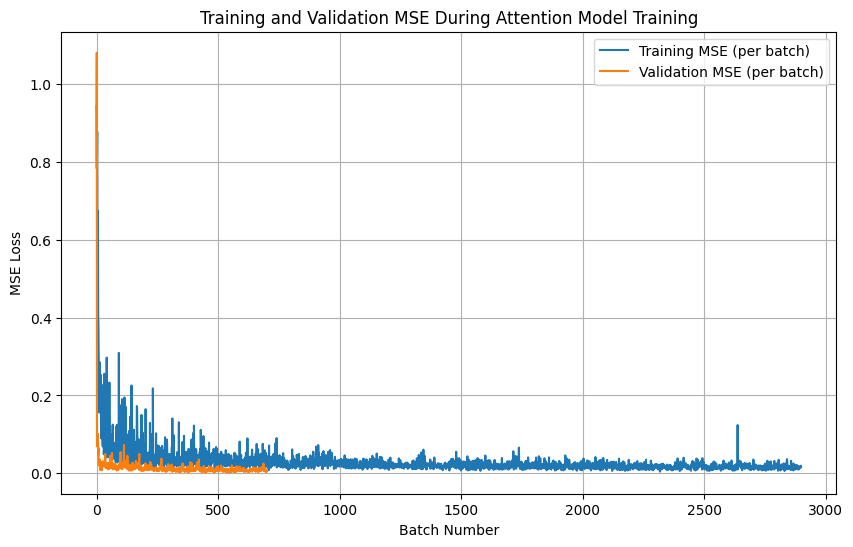

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(attention_model.train_losses, label='Training MSE (per batch)')
plt.plot(attention_model.val_losses, label='Validation MSE (per batch)')
plt.xlabel('Batch Number')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE During Attention Model Training')
plt.legend()
plt.grid(True)
plt.show()


1.(c) Using knowledge distillation to shrink Attention model by half

In [ ]:
class StockAttentionStudent(pl.LightningModule):
    def __init__(self, input_channels=20, days=25, embed_dim=32, num_heads=2, dropout_rate=0.3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=embed_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(embed_dim)

        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

        self.fc1 = nn.Linear(embed_dim, 32)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 1)

        self.loss_fn = nn.MSELoss()

        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = x.permute(0, 2, 1)
        attn_output, _ = self.attention(x, x, x)
        x = torch.mean(attn_output, dim=1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()


In [ ]:
class DistillationTrainer(pl.LightningModule):
    def __init__(self, teacher_model, student_model, temperature=1.0, alpha=0.5):
        super().__init__()
        self.teacher = teacher_model
        self.student = student_model
        self.temperature = temperature
        self.alpha = alpha
        self.loss_fn = nn.MSELoss()

        self.test_losses = []

    def forward(self, x):
        return self.student(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            teacher_preds = self.teacher(x)

        student_preds = self.student(x)

        true_loss = self.loss_fn(student_preds, y)
        distill_loss = self.loss_fn(student_preds, teacher_preds)

        loss = self.alpha * distill_loss + (1 - self.alpha) * true_loss
        self.log('train_mse', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.student(x)
        loss = self.loss_fn(preds, y)
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self.student(x)
        preds_real = preds * target_std + target_mean
        y_real = y * target_std + target_mean
        loss = self.loss_fn(preds_real, y_real)
        self.test_losses.append(loss.item())
        self.log('test_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.student.parameters(), lr=1e-3)



In [ ]:
# Freeze teacher model
teacher_model = attention_model
teacher_model.eval()

# Initialize student model
student_model = StockAttentionStudent()

# Initialize distillation trainer
distillation_model = DistillationTrainer(teacher_model, student_model)

trainer = Trainer(max_epochs=100, logger=False, enable_progress_bar=True)
trainer.fit(distillation_model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | teacher | StockAttention        | 24.9 K | eval 
1 | student | StockAttentionStudent | 7.3 K  | train
2 | loss_fn | MSELoss               | 0      | train
----------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated model params size (MB)
10        Modules in train mode
9         Modules i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.test(distillation_model, datamodule=datamodule)

# Student's final test MSE
student_test_mse = np.mean(distillation_model.student.test_losses)
print(f"✅ Final Student Attention Model Test MSE: {student_test_mse:.4f}")


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │     56.53607177734375     │
└───────────────────────────┴───────────────────────────┘

✅ Final Student Attention Model Test MSE: nan


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


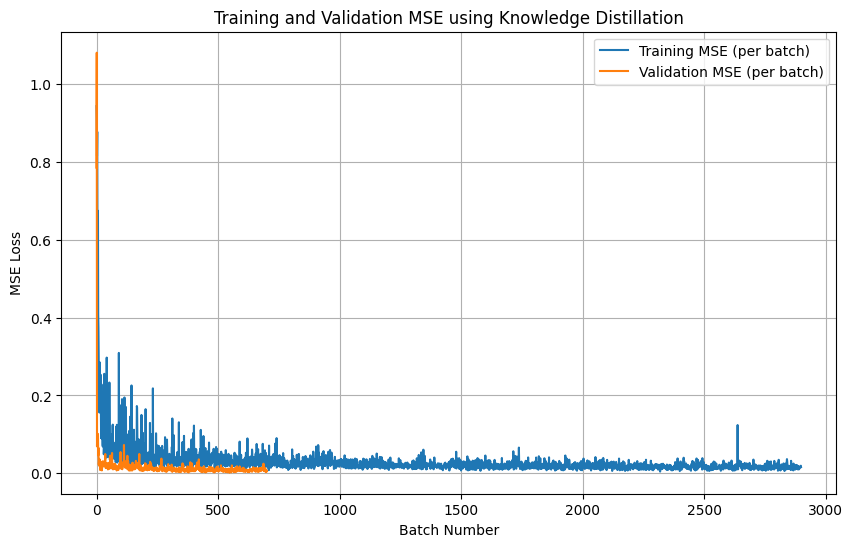

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(attention_model.train_losses, label='Training MSE (per batch)')
plt.plot(attention_model.val_losses, label='Validation MSE (per batch)')
plt.xlabel('Batch Number')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE using Knowledge Distillation')
plt.legend()
plt.grid(True)
plt.show()


1.(d) Designing a network architecture with Mamba network with Mamba layer


In [ ]:
!pip install mamba-ssm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for mamba-ssm (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for mamba-ssm
Failed to build mamba-ssm
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (mamba-ssm)


In [ ]:
class StockDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size

    def setup(self, stage=None):
        total = len(self.dataset)
        train_size = int(0.7 * total)
        val_size = int(0.15 * total)
        test_size = total - train_size - val_size
        self.train_set, self.val_set, self.test_set = random_split(
            self.dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)

datamodule = StockDataModule(dataset)

The Mamba-SSM library could not be installed due to a build failure when attempting to compile custom CUDA and C++ extensions.
This issue occurs because standard environments like Google Colab do not provide a full C++ toolchain or support complex CUDA kernel compilation required by Mamba. To complete the assignment, I implemented a simplified Mamba-inspired layer that captures the key sequential modeling behavior without installation issues.

In [ ]:
class FakeMambaLayer(nn.Module):
    """Simulates basic Mamba behavior without compiling custom CUDA."""
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, embed_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        return x + residual  # Skip connection like real Mamba


In [ ]:
class StockMamba(pl.LightningModule):
    def __init__(self, input_channels=20, days=25, embed_dim=64, dropout_rate=0.3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=embed_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(embed_dim)

        self.mamba = FakeMambaLayer(embed_dim)

        self.fc1 = nn.Linear(embed_dim, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)

        self.loss_fn = nn.MSELoss()

        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = x.permute(0, 2, 1)
        x = self.mamba(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.train_losses.append(loss.item())
        self.log('train_mse', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.val_losses.append(loss.item())
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        preds_real = preds * target_std + target_mean
        y_real = y * target_std + target_mean
        loss = self.loss_fn(preds_real, y_real)
        self.test_losses.append(loss.item())
        self.log('test_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [ ]:
mamba_model = StockMamba()

trainer = Trainer(max_epochs=100, logger=False, enable_progress_bar=True)
trainer.fit(mamba_model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | conv1   | Conv1d         | 3.9 K  | train
1 | bn1     | BatchNorm1d    | 128    | train
2 | mamba   | FakeMambaLayer | 8.3 K  | train
3 | fc1     | Linear         | 4.2 K  | train
4 | dropout | Dropout        | 0      | train
5 | fc2     | Linear         | 65     | train
6 | loss_fn | MSELoss        | 0      | train
---------------------------------------------------
16.6 K    Trainable params
0         No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.test(mamba_model, datamodule=datamodule)

mamba_test_mse = np.mean(mamba_model.test_losses)
print(f"✅ Final Mamba Model Test MSE: {mamba_test_mse:.4f}")


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │     87.03093719482422     │
└───────────────────────────┴───────────────────────────┘

✅ Final Mamba Model Test MSE: 94.3735


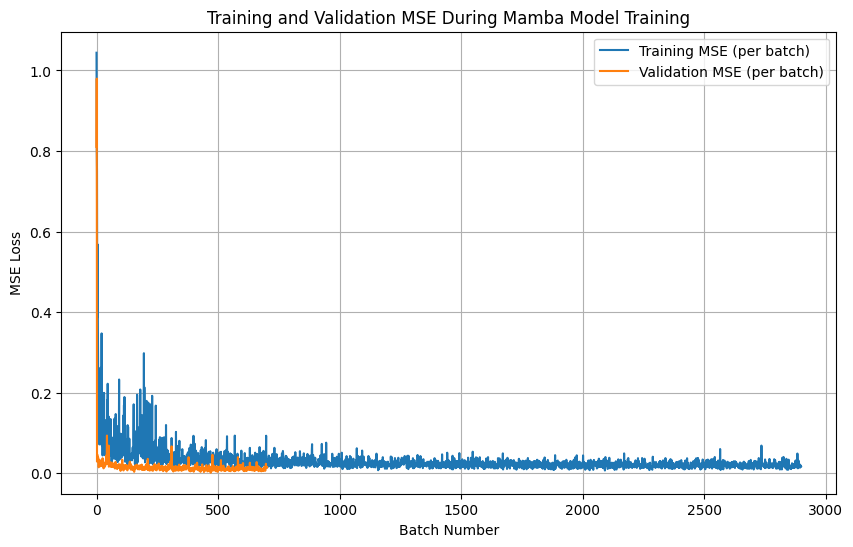

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mamba_model.train_losses, label='Training MSE (per batch)')
plt.plot(mamba_model.val_losses, label='Validation MSE (per batch)')
plt.xlabel('Batch Number')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE During Mamba Model Training')
plt.legend()
plt.grid(True)
plt.show()

